In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib ipympl

In [9]:
# Inventing a reference trajectory that is straight, through a bend, and straight again
bend_length = 3
bend_angle = np.deg2rad(60.)
side_angle = np.pi/2 - bend_angle
bend_R = bend_length / bend_angle

def bend_start():
    return -bend_R*np.sin(bend_angle/2), bend_R*np.cos(bend_angle/2) - bend_R

def reference_trajectory(s):
    s1x, s1y = bend_start()
    s2x, s2y = -s1x, s1y
    if s < -bend_length/2:
        # straight
        return s1x + (s+bend_length/2)*np.cos(bend_angle/2), s1y + (s+bend_length/2)*np.sin(bend_angle/2)
    elif s < bend_length/2:
        # bend
        return bend_R*np.sin(s/bend_R), bend_R*np.cos(s/bend_R) - bend_R
    else:
        # straight
        return s2x + (s-bend_length/2)*np.cos(bend_angle/2), s2y - (s-bend_length/2)*np.sin(bend_angle/2)

def reference_perp_angle(s):
    if s < -bend_length/2:
        return np.pi/2 + bend_angle/2
    elif s < bend_length/2:
        return np.pi/2 + bend_angle/2 - (s + bend_length/2)/bend_R
    else:
        return np.pi/2 - bend_angle/2
        

In [10]:
# Getting the closest distance to the aperture
def find_perp_distance(s, aper):
    sin_t = np.sin(reference_perp_angle(s))
    cos_t = np.cos(reference_perp_angle(s))
    sx, sy = reference_trajectory(s)
    for p1, p2 in zip(aper[:-1], aper[1:]):
        # SOLVE( [l*p1[0] + (1-l)*p2[0] == sx + u*np.cos(t), l*p1[1] + (1-l)*p2[1] == sy + u*np.sin(t)], [l,u] )
        l = ((sy - p2[1])*cos_t - (sx - p2[0])*sin_t)/((p1[1] - p2[1])*cos_t - (p1[0] - p2[0])*sin_t)
        if 0 <= l <= 1:
            # Crossed the segment
            u = (p1[1]*(p2[0] - sx) + p2[1]*sx - p2[0]*sy - p1[0]*(p2[1] - sy))/((p1[1] - p2[1])*cos_t - (p1[0] - p2[0])*sin_t)
            return u

In [11]:
# Create points for a dipole
dipole_upper = np.array([[-1,0.2], [1,0.2], [1,1.2], [-1,1.2], [-1,0.2]])
dipole_lower = np.array([[-1,-0.8], [1,-0.8], [1,-1.8], [-1,-1.8], [-1,-0.8]])

# Create points for a quadrupole
x_q, y_q = reference_trajectory(3)
xu_q  = x_q + 0.5*np.cos(bend_angle)
xl_q  = x_q - 0.5*np.cos(bend_angle)
yu_q  = y_q + 0.5*np.sin(bend_angle)
yl_q  = y_q - 0.5*np.sin(bend_angle)
dx_q  = 2*np.cos(side_angle)
dy_q  = 2*np.sin(side_angle)
dlx_q = np.cos(bend_angle)
dly_q = np.sin(bend_angle)
quad_upper = np.array([[xu_q, yu_q], [xu_q+dx_q, yu_q-dy_q], [xu_q+dx_q+dlx_q, yu_q-dy_q+dly_q], [xu_q+dlx_q, yu_q+dly_q], [xu_q, yu_q]])
quad_lower = np.array([[xl_q, yl_q], [xl_q+dx_q, yl_q-dy_q], [xl_q+dx_q-dlx_q, yl_q-dy_q-dly_q], [xl_q-dlx_q, yl_q-dly_q], [xl_q, yl_q]])

In [12]:
# Create points for the aperture
first_u = dipole_upper[0] + [(-3.5+bend_length/2)*np.cos(bend_angle/2), (-3.5+bend_length/2)*np.sin(bend_angle/2)]
first_l = dipole_lower[0] + [(-3.5+bend_length/2)*np.cos(bend_angle/2), (-3.5+bend_length/2)*np.sin(bend_angle/2)]
pipe_upper = np.array([first_u ,
                       dipole_upper[0] + [-0.3,0], dipole_upper[1] + [0.3,0], dipole_upper[1] + [0.8,0],
                       quad_upper[0] + [-0.3*np.sin(bend_angle), 0.3*np.cos(bend_angle)], quad_upper[1]
                      ])
pipe_lower = np.array([first_l,
                       dipole_lower[0] + [-0.3,0], dipole_lower[1] + [0.3,0], dipole_lower[1] + [0.8,0],
                       quad_lower[0] + [-0.3*np.sin(bend_angle), 0.3*np.cos(bend_angle)], quad_lower[1]
                       ])

Text(0, 0.5, '$d_\\text{aper}$')

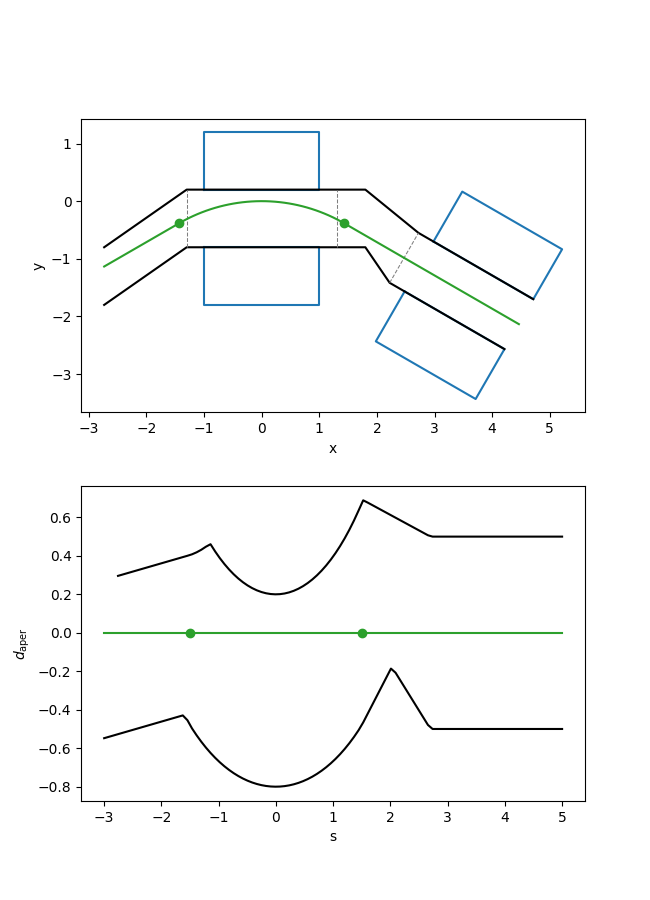

In [13]:
s = np.linspace(-3, 5, 100)
fig, ax = plt.subplots(2, 1, figsize=(6.5, 9))

ax[0].plot(*dipole_upper.T, c='tab:blue')
ax[0].plot(*dipole_lower.T, c='tab:blue')
ax[0].plot(*quad_upper.T, c='tab:blue')
ax[0].plot(*quad_lower.T, c='tab:blue')
ax[0].plot(*pipe_upper.T, c='k')
ax[0].plot(*pipe_lower.T, c='k')
ax[0].plot(*np.array([pipe_lower[1],pipe_upper[1]]).T, c='tab:gray', ls='--', lw=0.75)
ax[0].plot(*np.array([pipe_lower[2],pipe_upper[2]]).T, c='tab:gray', ls='--', lw=0.75)
ax[0].plot(*np.array([pipe_lower[4],pipe_upper[4]]).T, c='tab:gray', ls='--', lw=0.75)
ax[0].set_aspect('equal', 'box')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

traj = np.array([reference_trajectory(ss) for ss in s])
ax[0].plot(*traj.T, c='tab:green')
bend_points = np.array([reference_trajectory(ss) for ss in [-bend_length/2, bend_length/2]])
ax[0].scatter(*bend_points.T, c='tab:green')

ax[1].plot(s, np.zeros(len(s)), c='tab:green')
ax[1].scatter([-bend_length/2, bend_length/2], np.zeros(2), c='tab:green')
aper_upper = np.array([find_perp_distance(ss, pipe_upper) for ss in s])
aper_lower = np.array([find_perp_distance(ss, pipe_lower) for ss in s])
ax[1].plot(s, aper_upper, c='k')
ax[1].plot(s, aper_lower, c='k')
ax[1].set_xlabel('s')
ax[1].set_ylabel(r'$d_\text{aper}$')

Apertures en plotters vergelijken (Federica en Gianni)

# Redraw with exact measures

In [14]:
l_mec_mbb = 6.2
l_magn_mbb = 6.260018602780449

offset_end_mbb = 4.4e-3
offset_nom = 5.3e-3

l_vebb = 6.64
l_vcad = 1.422